In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

we just extracted the PacBio data read-ids, or how they call them `qnames` https://pacbiofileformats.readthedocs.io/en/3.0/BAM.html#qname-convention

we did it like so:
```
samtools view -@2 m54328_190622_144736.subreads.bam | cut -f1 > m54328_190622_144736.subreads.csv
samtools view -@2 m54328_190622_144736.scraps.bam | cut -f1 > m54328_190622_144736.scraps.csv
```

it actually takes >~ 30 mins ! whatever ...

In [7]:
scraps = "../data/m54328_190622_144736.scraps.ids.csv"
subreads = "../data/m54328_190622_144736.subreads.ids.csv"
ccs = "../data/ccs_statistics.csv.zip"

scraps_sam = "../data/m54328_190622_144736.scraps.short.sam"
subreads_sam = "../data/m54328_190622_144736.subreads.short.sam"

scraps = pd.read_csv(scraps, header=None, squeeze=True)
subreads = pd.read_csv(subreads, header=None, squeeze=True)
ccs = pd.read_csv(ccs, squeeze=True)

scraps_sam = pd.read_csv(scraps_sam, header=None, squeeze=True,sep='\t')
subreads_sam = pd.read_csv(subreads_sam, header=None, squeeze=True,sep='\t')


PacBio read id : `{movieName}/{holeNumber}/{qStart}_{qEnd}`

CCS read id structure is: `{movieName}/{holeNumber}/ccs`

Now let's extract the `holeNumber` (aka `wellid`) and `qStart`,`qEnd` information from read-IDs

we'll start with the consensus stuff (CCS), it does not have `qStart/Stop` in the read-ID, though


Here are some additional fileds that one can extract from the `scrap` output `.bam`:
```
'np', 'qe', 'qs', 'rq', 'sn', 'zm', 'RG', 'sc', 'sz'
```

and here are for the `subread` output `.bam`-s:
```
'cx', 'np', 'qe', 'qs', 'rq', 'sn', 'zm', 'RG'
```

!!!These are per-read type of flags
there are also per-nucleotide type of flags - too big to deal with right now ...

explanations for [COMMON flags](https://pacbiofileformats.readthedocs.io/en/5.1/BAM.html#use-of-read-tags-for-per-read-base-information) (subreads and scraps share):

\[redundant and useless ones\]
1. `qs`, `qe` - `qStart` and `qEnd` - as simple as that - should coincide whatever is in the `readID`, aka `qName` ...
2. `zm` - ID of the well (hole, etc - whatever corresponds to the single nucleotide reading enzyme - polymerase) - should correspond to `qName` ...
3. `np` - number of passes - should be `1` for scraps and subreads everywhere - important only for CCS ?!

\[interesting ones\]
4. `rq` - read quality/accuracy - predicted, whatever that means, `0.<rq<1.`
5. `sn` - signal to noise per `ACGT`(in that order) - over this HQ region
6. `RG` - read group ... [hard to interpret](https://pacbiofileformats.readthedocs.io/en/5.1/BAM.html#use-of-headers-for-file-level-information)

[SCRAPE-specific ones](https://pacbiofileformats.readthedocs.io/en/5.1/BAM.html#how-to-annotate-scrap-reads):
1. `sz` - ZMW classification: N-normal?!, C-control?!, M-malformed?!, or S-sentinel
2. `sc` - scrap region annotation: A-adapter, B-barcode, L-LQRegion(low quality region - part of HQ or not ...), F-filtered (undesirable subreads - artifactual wtf?! or too short )?! - require exploration ...

SUBREAD-specific ones:
1. `cx` - [subread context](https://pacbiofileformats.readthedocs.io/en/5.1/BAM.html#subread-local-context) - location with respect to adapter/barcode `+` or `-` pass  ...

In [78]:
# extract the required CCS information ...
ccs_df = ccs['qname']. \
                str. \
                extract(r'(.+)\/(.+)\/ccs'). \
                rename({0:"cellid", 1:"wellid"},axis=1)
ccs_df["qlen_ccs"] = ccs['qlen']
ccs_df["npasses_ccs"] = ccs['npasses']

ccs_df = ccs_df.set_index('wellid')[["qlen_ccs","npasses_ccs"]]

print(ccs_df.shape)

(1709, 2)


### create a little function to extract qname info and some basic stats from raw data ...

this would work both for subreads and for scraps

 - we will be extracting `wellid`,  and `qstart` , `qstop`
 - calculating `qlen`, which is `qstop - qstart`
 - and then grouping by `wellid` to generate some more stats on the `qlen` of different fragments ...

In [49]:
def wellstats_raw(raw_qnames):
    """
    given a df or series of qnames (pacbio readids)
    this function would generate a df with a bunch
    of columns describing output of each well ...
    """
    raw_qnames_df = raw_qnames. \
                        str. \
                        extract(r'(.+)\/(.+)\/(\d+)\_(\d+)'). \
                        rename({0:"cellid", 1:"wellid",2:"qstart",3:"qstop"},axis=1)
    # calculate span
    raw_qnames_df["qlen"] = \
        raw_qnames_df["qstop"].astype(int) - \
            raw_qnames_df["qstart"].astype(int)
    
    # # just a little test ...
    # print(raw_qnames_df[raw_qnames_df["wellid"]=="25953225"])

    # group it by WellID and collect the qlen
    # npases, qlen mean and std ...
    
    _ = raw_qnames_df[['wellid','qlen']].groupby('wellid').sum()
    # wellid becomes an index and assigning new columns like that
    # should be taking care of an index matching just fine ...
    _['npases'] = raw_qnames_df['wellid'].value_counts()
    _['qlen_avg'] = raw_qnames_df[['wellid','qlen']].groupby('wellid').median()
    _['qlen_std'] = raw_qnames_df[['wellid','qlen']].groupby('wellid').std()
    # _.sort_values(by="npases")
    # print(raw_qnames_df.shape)
    return _

### apply well stats extraction to both subreads and scraps ...

In [50]:
subread_df = wellstats_raw(subreads)
scrap_df = wellstats_raw(scraps)

### we should start merging and comparing them ...

let's merge subreads, scraps and CCS by the `wellid` and just explore it:
 1. what's so special about ~1500 reads that have a CCS, i.e. consensus ?
 2. are there wells with scraps, but no subreads ? how many ?
 3. are there wells with subreads, but no scraps ? how many ? (strange category - how is it possible?)
 4. total number of uniq wells the both scraps and subreads are reffering to - PacBio Sequel has 1M wells ...
 5. how many nucleotides does each well generate ? `total_qlen_scr + total_qlen_sub` - basically ...

In [81]:
sub_scr = subread_df.merge(scrap_df,'outer',left_index=True,right_index=True,suffixes=('_sub','_scr'))
sub_scr_ccs = _.merge(ccs_df,'outer',left_index=True,right_index=True )

### 1. what's so special about those that have consensus ? ...

In [90]:
ccs_special = sub_scr_ccs[sub_scr_ccs['npasses_ccs']>0]
ccs_special

,qlen_sub,npases_sub,qlen_avg_sub,qlen_std_sub,qlen_scr,npases_scr,qlen_avg_scr,qlen_std_scr,qlen_ccs,npasses_ccs
wellid,,,,,,,,,,
10027363,78867.0,8.0,9631.0,4005.539055,41621.0,9.0,46.0,13652.628631,14946.0,6.0
10027999,138016.0,21.0,6714.0,646.276614,9142.0,21.0,45.0,1790.565981,6656.0,17.0
10092637,152210.0,34.0,4672.0,911.953882,27279.0,35.0,44.0,3663.095285,4628.0,31.0
10093468,121281.0,11.0,11669.0,2324.990080,516.0,10.0,47.5,8.329332,11056.0,6.0
10093473,117050.0,10.0,11972.5,2982.138569,464.0,9.0,52.0,5.790318,13357.0,8.0
...,...,...,...,...,...,...,...,...,...,...
9831015,69876.0,7.0,11346.0,2639.134878,48681.0,7.0,45.0,18280.188829,11247.0,4.0
9896308,68446.0,5.0,21069.0,10333.109561,54572.0,6.0,47.0,21886.753607,20906.0,3.0
9896428,87052.0,6.0,18719.0,7370.945385,118632.0,7.0,47.0,40856.172389,18514.0,4.0


observations - not all of the subreads go into CCS, scaraps looks uniform in size - adaptors only ?!

### 2. wells with scraps but without subreads ...

In [91]:
scr_without_sub = sub_scr_ccs[(sub_scr_ccs['npases_scr']>0)&(sub_scr_ccs['npases_sub'].isnull())]

scr_without_sub

,qlen_sub,npases_sub,qlen_avg_sub,qlen_std_sub,qlen_scr,npases_scr,qlen_avg_scr,qlen_std_scr,qlen_ccs,npasses_ccs
wellid,,,,,,,,,,
10027072,NaN,NaN,NaN,NaN,5729.0,1.0,5729.0,NaN,NaN,NaN
10027074,NaN,NaN,NaN,NaN,121220.0,1.0,121220.0,NaN,NaN,NaN
10027078,NaN,NaN,NaN,NaN,879.0,1.0,879.0,NaN,NaN,NaN
10027089,NaN,NaN,NaN,NaN,27025.0,1.0,27025.0,NaN,NaN,NaN
10027100,NaN,NaN,NaN,NaN,1613.0,1.0,1613.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9962485,NaN,NaN,NaN,NaN,33.0,1.0,33.0,NaN,NaN,NaN
9962486,NaN,NaN,NaN,NaN,60314.0,1.0,60314.0,NaN,NaN,NaN
9962487,NaN,NaN,NaN,NaN,23.0,1.0,23.0,NaN,NaN,NaN


number of passes (pieces) and total number of nucleotides in such scrapes ...

1.0      232508
3.0       56800
2.0       27646
5.0        1473
4.0         466
          ...  
213.0         1
124.0         1
176.0         1
184.0         1
423.0         1
Name: npases_scr, Length: 163, dtype: int64

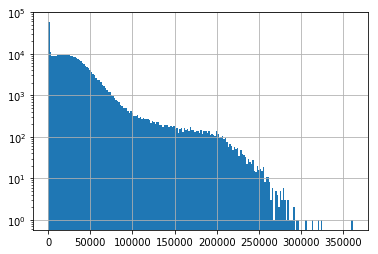

In [107]:
scr_without_sub['qlen_scr'].hist(log=True,bins=200)
scr_without_sub['npases_scr'].value_counts()

 - ~300'000 well did not yield any subreads ...
 - a lot of them are short and have 1 pass, but there multi-pass ones with a ton of nucleotides ...

### 3. wells with subreads but without scraps ... wtf is that ?

In [108]:
sub_without_scr = sub_scr_ccs[(sub_scr_ccs['npases_sub']>0)&(sub_scr_ccs['npases_scr'].isnull())]

sub_without_scr

,qlen_sub,npases_sub,qlen_avg_sub,qlen_std_sub,qlen_scr,npases_scr,qlen_avg_scr,qlen_std_scr,qlen_ccs,npasses_ccs
wellid,,,,,,,,,,
10027076,11719.0,1.0,11719.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10027105,10900.0,1.0,10900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10027133,22970.0,1.0,22970.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10027204,35348.0,1.0,35348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10027270,21011.0,1.0,21011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9961976,18976.0,1.0,18976.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9962273,19876.0,1.0,19876.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9962421,11101.0,1.0,11101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


number of passes (pieces) and total number of nucleotides in such subreads ...

1.0    20397
Name: npases_sub, dtype: int64

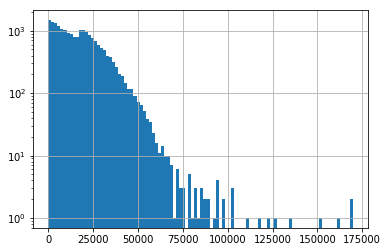

In [111]:
sub_without_scr['qlen_sub'].hist(log=True,bins=100)
sub_without_scr['npases_sub'].value_counts()

 - a-ha! these are all 1-pass subreads that didn't have their adaptors sequences ?! or whatever ...
 - there are ~20'000 of them ...

### 4. total number of uniq wells the both scraps and subreads are reffering to - PacBio Sequel has 1M wells ...

In [112]:
len(sub_scr_ccs)

1015433

https://www.pacb.com/products-and-services/sequel-system/

Sequel has 1M wells - and we got a little over 1M of unique wellids

- where does the surplus come from  ?!

is 1M an approximate number or what ...

### 5. how many nucleotides does each well generate ? total_qlen_scr + total_qlen_sub - basically ...

In [116]:
nucs = sub_scr_ccs['qlen_scr'].fillna(0)+sub_scr_ccs['qlen_sub'].fillna(0)

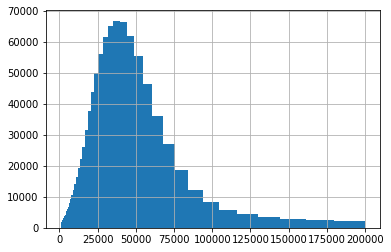

In [122]:
nucs.hist(log=False,bins= np.geomspace(1000,200000))

to be continued ...